# Машинное обучение, ФКН ВШЭ

## Exploratory Data Analysis и линейная регрессия

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [375]:
from setuptools.command.rotate import rotate
!pip install folium

zsh:1: command not found: pip


In [376]:
import folium

m = folium.Map(location=(50.97178, 9.79418), zoom_start=15)

m

In [377]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

## Часть 0. Подготовка

Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси.

In [378]:
data = pd.read_csv('./nyc-taxi-trip-duration/train.csv')
data.shape

(1458644, 11)

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [379]:
data = data.drop(columns=['dropoff_datetime'])

data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуем его гистограмму:

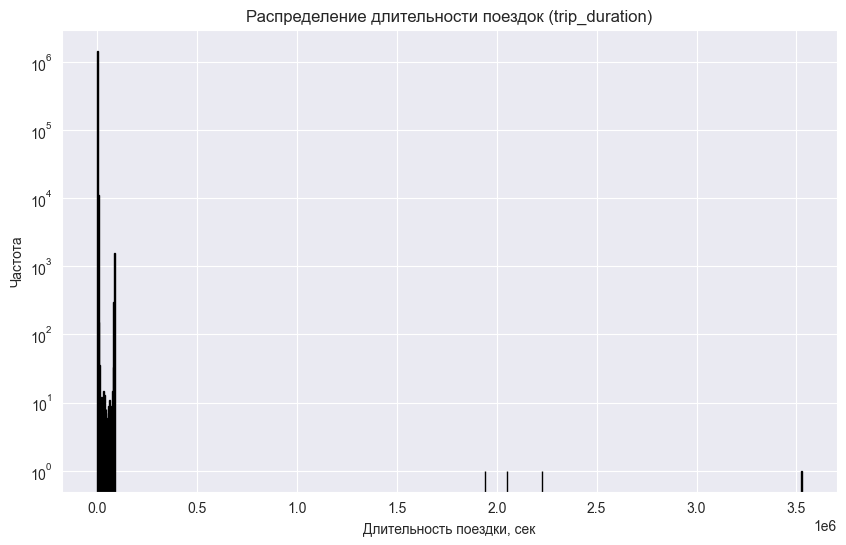

In [380]:
plt.figure(figsize=(10, 6))
plt.hist(data['trip_duration'], bins=1000, color='blue', edgecolor='black')
plt.title('Распределение длительности поездок (trip_duration)')
plt.xlabel('Длительность поездки, сек')
plt.ylabel('Частота')
plt.yscale('log')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

На гистограмме видны несколько точек с выбросами, кроме этого мы можем сказать, что наибольшая частота у самых коротких поездок, затем мы видим яму: частота поездок падает, а затем опять возрастает (хоть и не до конца)  

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Почему авторы соревнования выбрали именно RMSLE, а не RMSE?

1. В обучающей выборке мы заметили несколько выбросов, а RMSLE намного лучше справится с ними
2. Длительность поездки неотрицательная, так что мы смело можем использовать log
3. За счет использования логарифма одно и то же абсолютное значение ошибки будет иметь разный вес в итоговом результате в зависимости от реального значения длины поездки. Так, ошибка в +1 минуту будет иметь вес 0.3 при 2-минутной поездке и 0.05 при 20-минутной. Ну и в данной задаче такой подход выглядит разумно, так как длина поездки распределена отнюдь не равномерно.

Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

Покажем, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: 

$$
\text{MSE}(X, \hat{y}, a) \sim \text{RMSE}(X, \hat{y}, a) = 
\sqrt{\frac{1}{\ell} \sum_{i=1}^{\ell} \left(\hat{y}_i - \hat{a}(x_i)\right)^2} =
\sqrt{\frac{1}{\ell} \sum_{i=1}^{\ell} \left(\log(y_i + 1) - \log(a(x_i) + 1)\right)^2} = \text{RMSLE}(X, y, a)
$$

Итак, мы смогли свести задачу оптимизации rmsle к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавим к нашей выборке колонку `log_trip_duration` (воспользуемся `np.log1p`) и нарисуем гистограмму модифицированного таргета по обучающей выборке.

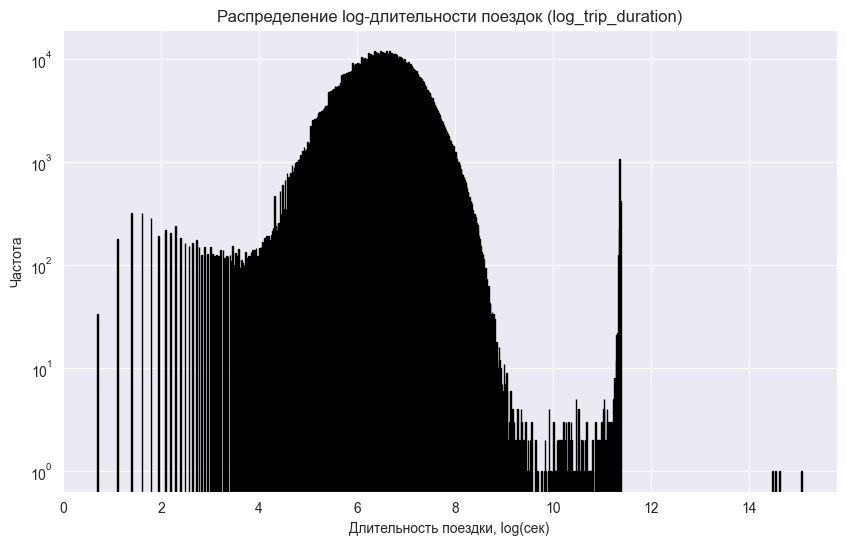

In [381]:
"""
    Как мы и ожидали распределение сжалось в сторону нуля, что поможет нам лучше справляться с выбросами
    Более того, оно стало более гладким и мы смогли разделить маленькие значения, которые до этого были почти равны 
"""
data['log_trip_duration'] = np.log1p(data['trip_duration'])

# data = data.drop(columns=['trip_duration'])  Оно нам еще нужно дальше

plt.figure(figsize=(10, 6))
plt.hist(data['log_trip_duration'], bins=1000, color='blue', edgecolor='black')
plt.title('Распределение log-длительности поездок (log_trip_duration)')
plt.xlabel('Длительность поездки, log(сек)')
plt.ylabel('Частота')
plt.yscale('log')
plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [382]:
def rmsle(log1p_y_true, log1p_y_pred):
    return np.sqrt(np.mean((log1p_y_true - log1p_y_pred) ** 2))


rmsle_best_const = rmsle(data['log_trip_duration'], data['log_trip_duration'].mean())
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411509


## Часть 1. Изучаем `pickup_datetime`

Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Построим график зависимости количества поездок от дня в году:

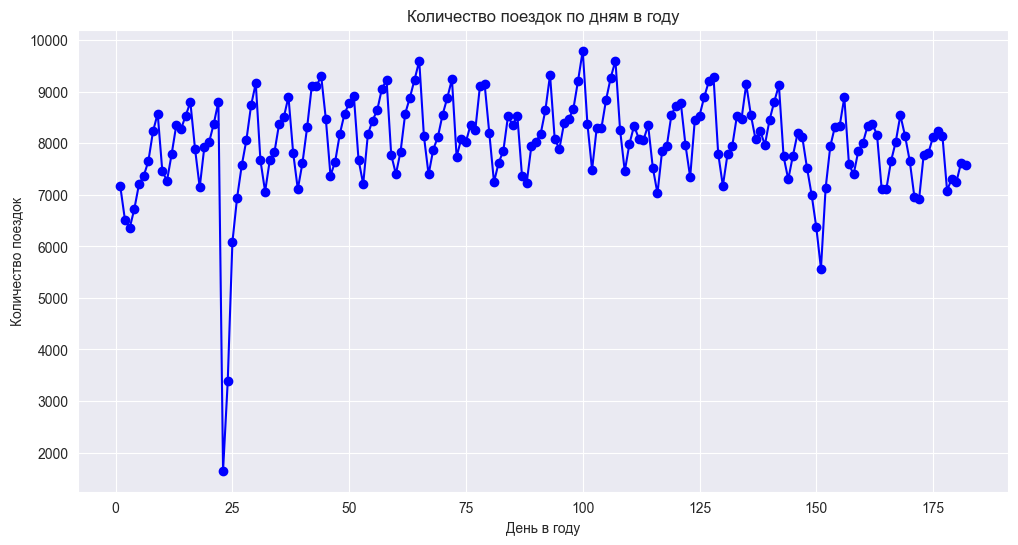

In [383]:
data['day_of_year'] = data['pickup_datetime'].dt.dayofyear

trips_per_day = data.groupby('day_of_year').size()

plt.figure(figsize=(12, 6))
plt.plot(np.array(trips_per_day.index), np.array(trips_per_day.values), color='blue', marker='o')
plt.title('Количество поездок по дням в году')
plt.xlabel('День в году')
plt.ylabel('Количество поездок')
plt.grid(True)
plt.show()

Заметим, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислим, в какие даты происходили эти скачки вниз и найдем информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуем графики зависимости количества поездок от дня недели и от часов в сутках:

In [384]:
mean_trips_per_day = trips_per_day.mean()
low_trip_days = trips_per_day[
    trips_per_day < mean_trips_per_day * 0.7]  # Считаем аномальными дни с числом поездок < 30% от среднего
dates_with_low_trips = data.loc[
    data['day_of_year'].isin(low_trip_days.index), 'pickup_datetime'].dt.date.unique()
print("Даты с аномально малым количеством поездок:", *dates_with_low_trips, sep="\n")

data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
data['hour_of_day'] = data['pickup_datetime'].dt.hour

Даты с аномально малым количеством поездок:
2016-01-23
2016-01-24
2016-05-30


2016-01-23 - 2016-01-24 -- снежная буря, власти запретили движение авто

2016-05-30 -- https://nypost.com/2016/05/16/


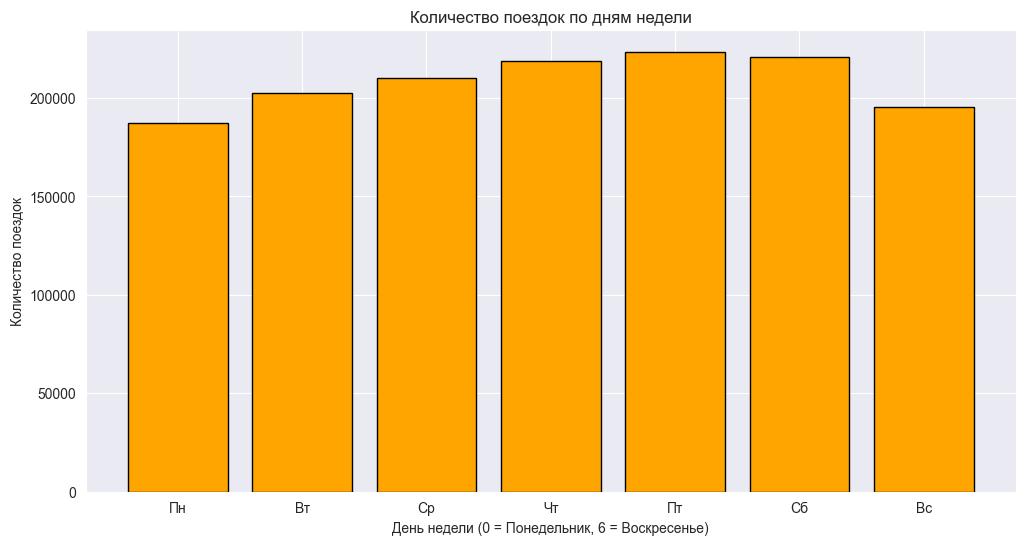

In [385]:
trips_per_weekday = data.groupby('day_of_week').size()

plt.figure(figsize=(12, 6))
plt.bar(np.array(trips_per_weekday.index), np.array(trips_per_weekday.values), color='orange', edgecolor='black')
plt.title('Количество поездок по дням недели')
plt.xlabel('День недели (0 = Понедельник, 6 = Воскресенье)')
plt.ylabel('Количество поездок')
plt.xticks(ticks=range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.grid(True)
plt.show()

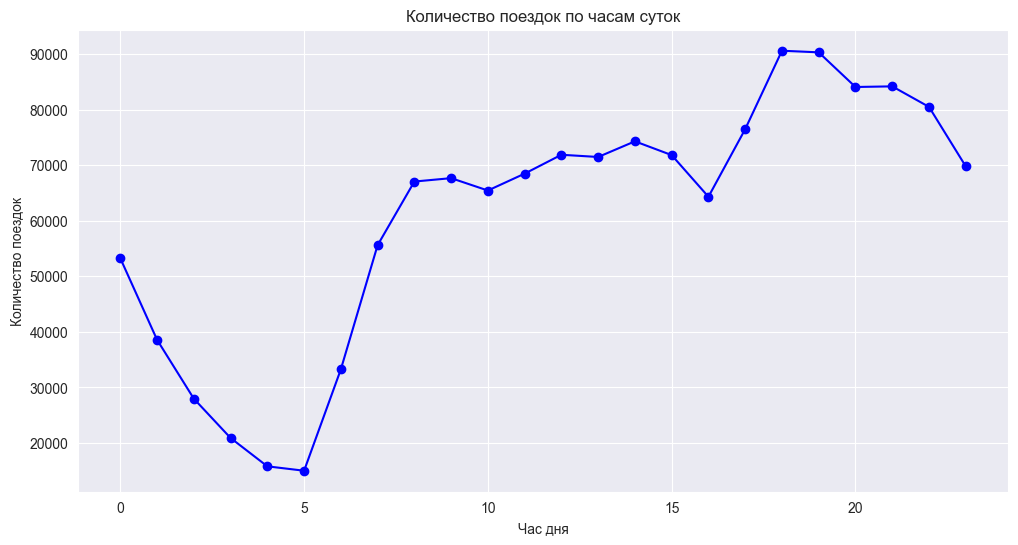

In [386]:
trips_per_hour = data.groupby('hour_of_day').size()

plt.figure(figsize=(12, 6))
plt.plot(np.array(trips_per_hour.index), np.array(trips_per_hour.values), marker='o', color='blue')
plt.title('Количество поездок по часам суток')
plt.xlabel('Час дня')
plt.ylabel('Количество поездок')
plt.grid(True)
plt.show()

Нарисуем на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, поищите, как это делается). Аналогично нарисуем зависимости количества поездок от часа в сутках для разных дней недели.

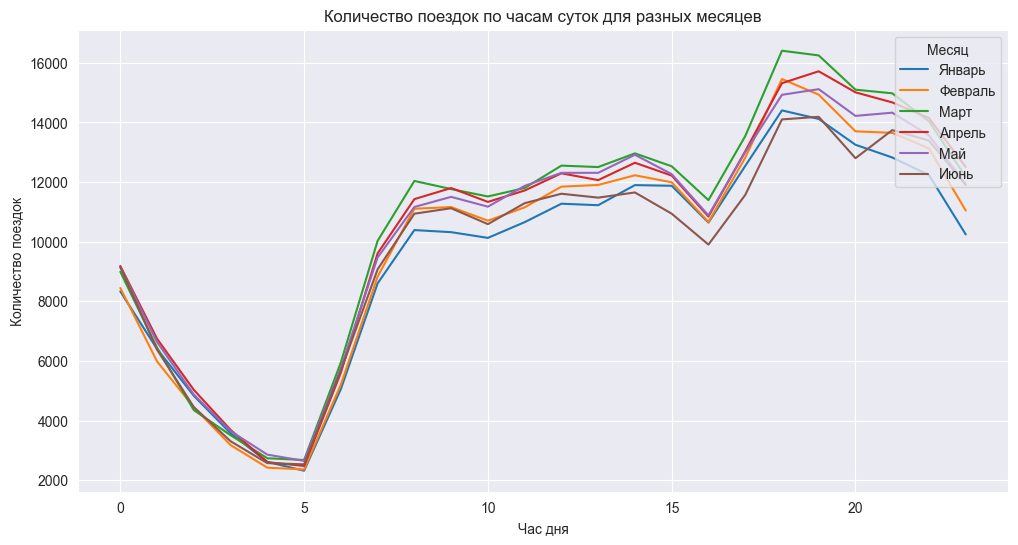

In [387]:
data['month'] = data['pickup_datetime'].dt.month

months = ["Январь", "Февраль", "Март", "Апрель", "Май", "Июнь"]

plt.figure(figsize=(12, 6))
for month in range(6):
    trips_per_hour_month = data[data['month'] == month + 1].groupby('hour_of_day').size()
    plt.plot(np.array(trips_per_hour_month.index), np.array(trips_per_hour_month.values), label=months[month])

plt.title('Количество поездок по часам суток для разных месяцев')
plt.xlabel('Час дня')
plt.ylabel('Количество поездок')
plt.legend(title='Месяц', loc='upper right')
plt.grid(True)
plt.show()

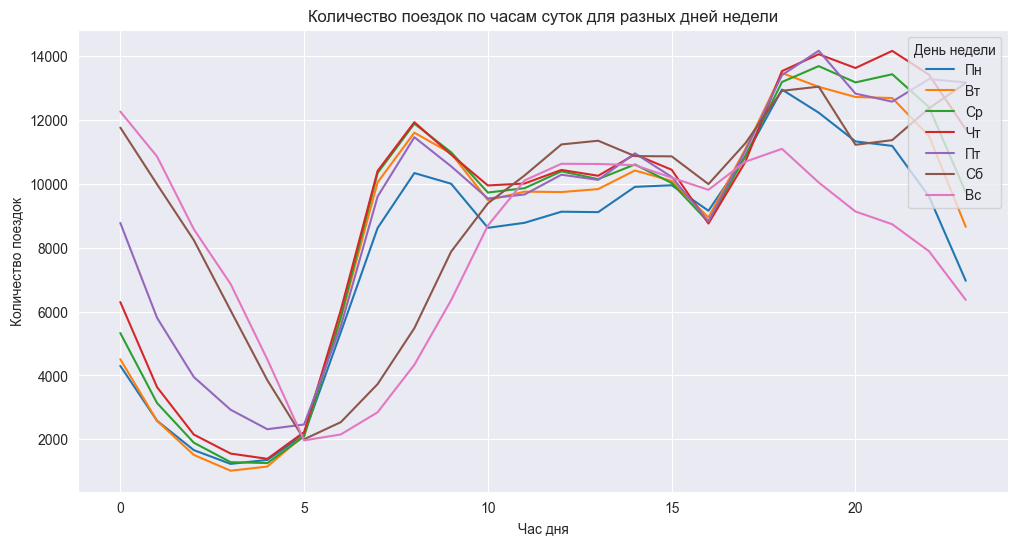

In [388]:
plt.figure(figsize=(12, 6))
for day in range(7):
    trips_per_hour_weekday = data[data['day_of_week'] == day].groupby('hour_of_day').size()
    plt.plot(np.array(trips_per_hour_weekday.index), np.array(trips_per_hour_weekday.values), label=f'День {day}')

plt.title('Количество поездок по часам суток для разных дней недели')
plt.xlabel('Час дня')
plt.ylabel('Количество поездок')
plt.legend(title='День недели', labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'], loc='upper right')
plt.grid(True)
plt.show()


**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

В среднем в 5 утра меньше всего поездок, в 18-22 больше всего (люди едут с работы). В январе чуть меньше поездок (по всей видимости из-за праздников). На выходных люди возвращаются домой позже.

Разобьем выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуем график зависимости среднего логарифма времени поездки от дня недели. Затем сделаем то же самое, но для часа в сутках и дня в году.

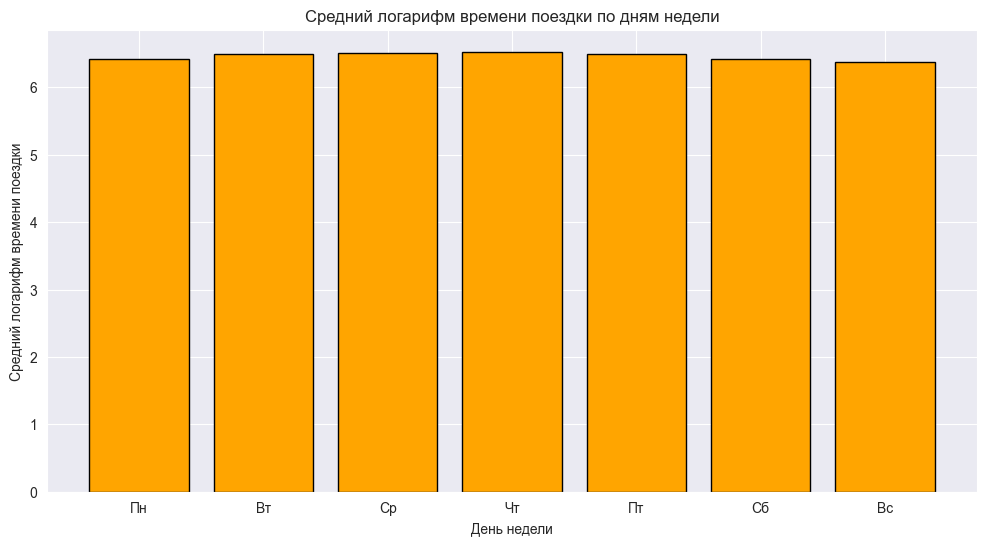

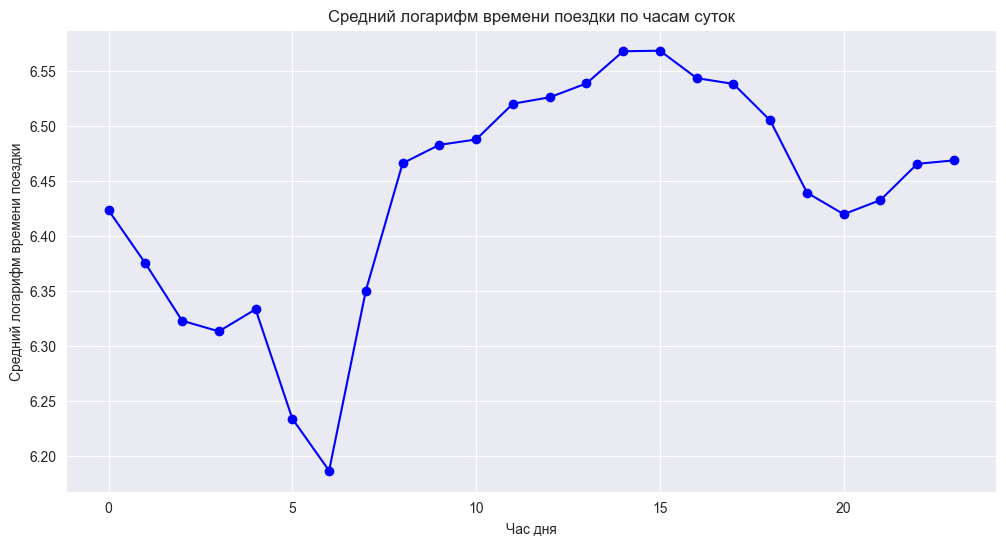

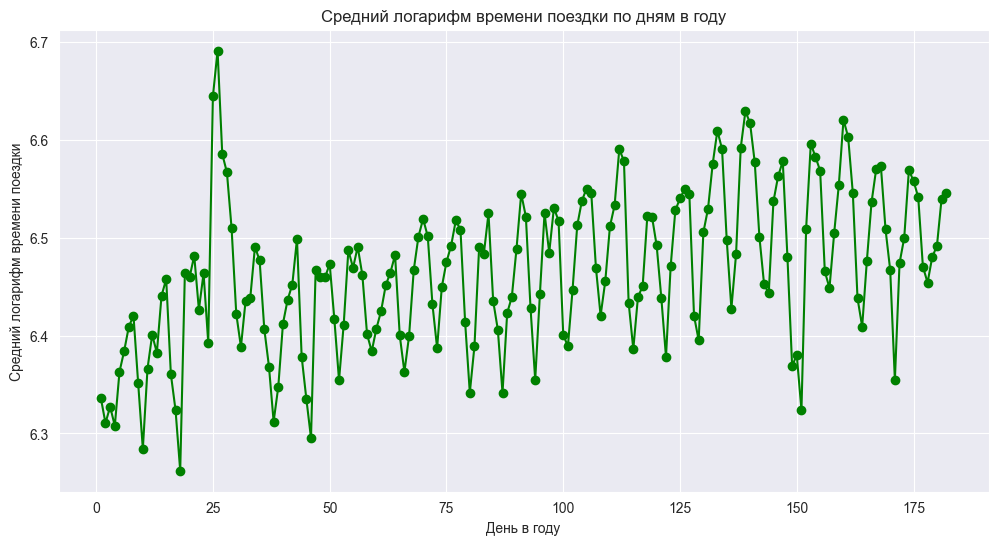

In [389]:
from sklearn.model_selection import train_test_split

train_data, _ = train_test_split(data, test_size=0.3, random_state=42)

# 1.
mean_log_duration_by_weekday = train_data.groupby('day_of_week')['log_trip_duration'].mean()

plt.figure(figsize=(12, 6))
plt.bar(np.array(mean_log_duration_by_weekday.index), np.array(mean_log_duration_by_weekday.values), color='orange',
        edgecolor='black')
plt.title('Средний логарифм времени поездки по дням недели')
plt.xlabel('День недели')
plt.ylabel('Средний логарифм времени поездки')
plt.xticks(ticks=range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.grid(True)
plt.show()

# 2.
mean_log_duration_by_hour = train_data.groupby('hour_of_day')['log_trip_duration'].mean()

plt.figure(figsize=(12, 6))
plt.plot(np.array(mean_log_duration_by_hour.index), np.array(mean_log_duration_by_hour.values), marker='o',
         color='blue')
plt.title('Средний логарифм времени поездки по часам суток')
plt.xlabel('Час дня')
plt.ylabel('Средний логарифм времени поездки')
plt.grid(True)
plt.show()

# 3.
mean_log_duration_by_day_of_year = train_data.groupby('day_of_year')['log_trip_duration'].mean()

plt.figure(figsize=(12, 6))
plt.plot(np.array(mean_log_duration_by_day_of_year.index), np.array(mean_log_duration_by_day_of_year.values),
         marker='o', color='green')
plt.title('Средний логарифм времени поездки по дням в году')
plt.xlabel('День в году')
plt.ylabel('Средний логарифм времени поездки')
plt.grid(True)
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Графики зависимости от дня недели и от часа в сутках не очень похожи, но между ними прослеживается зависимость: минимальные значения в понедельник и воскресенье (хотя лог-время поездки по дням недели примерно одинаковое), меньшие значения приходятся на утро, но при этом наибольшая длина поездки днем, а количество - вечером.  


Добавим следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [390]:
data['is_first_anomalous'] = data['pickup_datetime'].dt.date.isin(dates_with_low_trips[:2]).astype(int)
data['is_second_anomalous'] = data['pickup_datetime'].dt.date.isin([dates_with_low_trips[2]]).astype(int)

data

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,day_of_year,day_of_week,hour_of_day,month,is_first_anomalous,is_second_anomalous
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,74,0,17,3,0,0
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,164,6,0,6,0,0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,19,1,11,1,0,0
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,97,2,19,4,0,0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,86,5,13,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,N,778,6.658011,99,4,13,4,0,0
1458640,id1049543,1,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,N,655,6.486161,10,6,7,1,0,0
1458641,id2304944,2,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,N,764,6.639876,113,4,6,4,0,0
1458642,id2714485,1,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,N,373,5.924256,5,1,15,1,0,0


Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?


Как численные признаки мы можем рассмотреть день в году, а так же час в сутках, так как их интерпретация в числах наиболее приближена к их реальному смыслу. Но именно в этой задаче предлагаю рассмотреть час в сутках как категориальный признак, потому что с точки зрения таргета зависимость между днями недели не линейная, из-за часов-пик

Обучим `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируем с помощью `StandardScaler`. Используем только признаки, которые мы выделили в этой части задания.

In [391]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error

categorical_features = ['hour_of_day', 'day_of_week', 'month', 'is_first_anomalous', 'is_second_anomalous']
numerical_features = ['day_of_year']

train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
X_train, y_train = train_data[categorical_features + numerical_features], train_data['log_trip_duration']
X_test, y_test = test_data[categorical_features + numerical_features], test_data['log_trip_duration']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(random_state=42))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmsle = root_mean_squared_error(y_test, y_pred)
print(f'rmsle на валидационной выборке: {rmsle:.5f}')


rmsle на валидационной выборке: 0.78818


## Часть 2. Изучаем координаты
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки.

In [392]:
from typing import Iterable


def show_circles_on_map(
        latitude_values: Iterable[float],
        longitude_values: Iterable[float],
        color: str = "blue",
) -> folium.Map:
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    Works best on samples of size < 10k, too costly otherwise

    latitude_values: sample latitude values of a dataframe
    longitude_column: sample longitude values of a dataframe
    color: the color of circles to be drawn
    """

    location = (np.mean(latitude_values), np.mean(longitude_values))
    m = folium.Map(location=location)

    for lat, lon in zip(latitude_values, longitude_values):
        folium.Circle(
            radius=100,
            location=(lat, lon),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

Напишем функция, которая вернет значения колонок `pickup_latitude`, `pickup_longitude` на каком-нибудь разумном кусочке датафрейма, например, `df.sample(1000)` и покажем на карте, используя `show_circles_on_map`

In [393]:
your_lat_values = train_data.sample(1000, random_state=42)["pickup_latitude"]
your_lon_values = train_data.sample(1000, random_state=42)["pickup_longitude"]

show_circles_on_map(your_lat_values, your_lon_values, color="midnightblue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

Большая часть заказов вполне логично происходит на Манхеттене, но кроме этого мы можем заметить что выделяются два кластера точек в зоне аэропортов

Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`.

In [394]:
def haversine(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


data['haversine'] = haversine(data['pickup_latitude'].values,
                              data['pickup_longitude'].values,
                              data['dropoff_latitude'].values,
                              data['dropoff_longitude'].values)

data

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,day_of_year,day_of_week,hour_of_day,month,is_first_anomalous,is_second_anomalous,haversine
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,74,0,17,3,0,0,1.498521
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,164,6,0,6,0,0,1.805507
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,19,1,11,1,0,0,6.385098
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,97,2,19,4,0,0,1.485498
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,86,5,13,3,0,0,1.188588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,N,778,6.658011,99,4,13,4,0,0,1.225080
1458640,id1049543,1,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,N,655,6.486161,10,6,7,1,0,0,6.049836
1458641,id2304944,2,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,N,764,6.639876,113,4,6,4,0,0,7.824606
1458642,id2714485,1,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,N,373,5.924256,5,1,15,1,0,0,1.092564


Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишем логарифм `haversine` в отдельную колонку `log_haversine`:

In [395]:
data["log_haversine"] = np.log1p(data['haversine'])

In [396]:
print(data['log_trip_duration'].corr(data['haversine']),
      data['log_trip_duration'].corr(data['log_haversine']))

0.5735948311180239 0.7498822373942509


Давайте изучим среднюю скорость движения такси

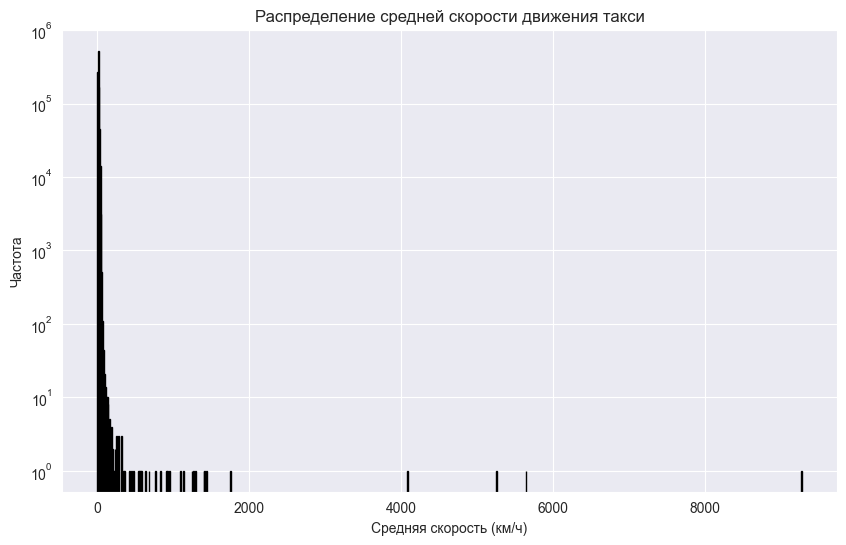

In [397]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
train_data['average_speed'] = train_data['haversine'] / (train_data['trip_duration'] / 3600)

plt.figure(figsize=(10, 6))
plt.hist(train_data['average_speed'], bins=1000, color='blue', edgecolor='black')
plt.title('Распределение средней скорости движения такси')
plt.xlabel('Средняя скорость (км/ч)')
plt.ylabel('Частота')
plt.yscale('log')
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуем гистограмму по объектам, для которых значение скорости получилось разумным:

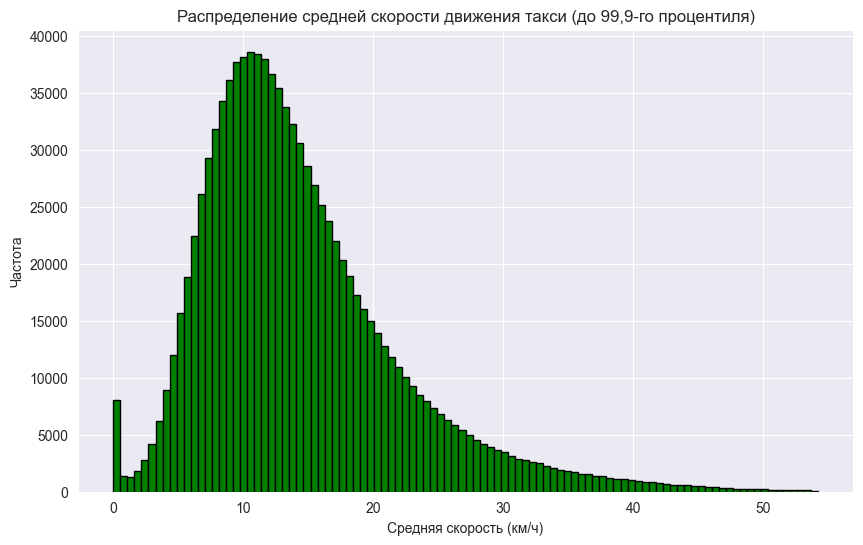

In [398]:
filtered_train = train_data[train_data['average_speed'] <= train_data['average_speed'].quantile(0.999)]

plt.figure(figsize=(10, 6))
plt.hist(filtered_train['average_speed'], bins=100, color='green', edgecolor='black')
plt.title('Распределение средней скорости движения такси (до 99,9-го процентиля)')
plt.xlabel('Средняя скорость (км/ч)')
plt.ylabel('Частота')
plt.show()

Для каждой пары (день недели, час суток) посчитаем медиану скоростей. Нарисуем Heatmap-график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

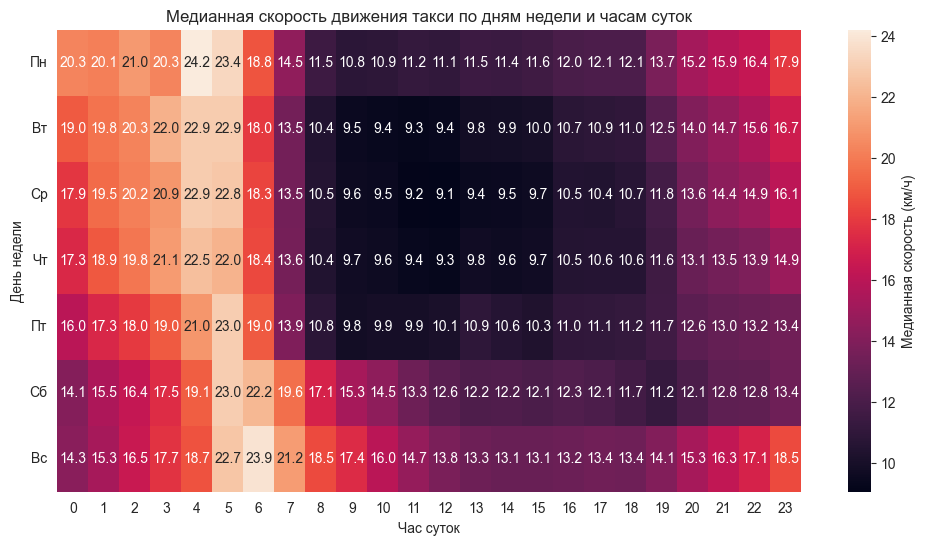

In [399]:
import seaborn as sns

median_speed = train_data.groupby(['day_of_week', 'hour_of_day'])['average_speed'].median().unstack()

# Построение тепловой карты
plt.figure(figsize=(12, 6))
sns.heatmap(median_speed, annot=True, fmt=".1f", cbar_kws={'label': 'Медианная скорость (км/ч)'})
plt.title('Медианная скорость движения такси по дням недели и часам суток')
plt.xlabel('Час суток')
plt.ylabel('День недели')
plt.yticks(ticks=np.arange(7) + 0.5, labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'], rotation=0)
plt.show()

In [400]:
# train_data = train_data.drop(columns=['average_speed']) можем не дропать, все равно на следующем train_test разбиении его не будет
data = data.drop(columns=['trip_duration'])  #  а вот продолжительность уже можем убрать
train_data

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,day_of_year,day_of_week,hour_of_day,month,is_first_anomalous,is_second_anomalous,haversine,log_haversine,average_speed
1011257,id2209155,2,2016-05-03 09:03:08,2,-73.979813,40.752529,-73.982681,40.763680,N,844,6.739337,124,1,9,5,0,0,1.263187,0.816774,5.388000
178550,id0586605,1,2016-01-01 16:40:51,1,-73.977623,40.746296,-73.968414,40.788933,N,1001,6.909753,1,4,16,1,0,0,4.804012,1.758549,17.277166
551460,id0467144,1,2016-04-24 13:57:03,1,-73.950699,40.779404,-73.863129,40.768608,N,1048,6.955593,115,6,13,4,0,0,7.471088,2.136659,25.664044
1434271,id0989010,2,2016-01-10 17:03:47,1,-73.984558,40.721802,-73.976753,40.752213,N,784,6.665684,10,6,17,1,0,0,3.444869,1.491750,15.818276
1173610,id0580742,1,2016-02-25 17:37:36,1,-73.967720,40.768742,-73.977173,40.789875,N,732,6.597146,56,3,17,2,0,0,2.481063,1.247338,12.201948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,id1753868,2,2016-03-25 07:11:49,2,-73.955032,40.777328,-74.006203,40.749424,N,1281,7.156177,85,4,7,3,0,0,5.310383,1.842196,14.923794
1414414,id2204747,1,2016-02-16 18:01:45,1,-73.973618,40.763920,-73.983849,40.749874,N,833,6.726233,47,1,18,2,0,0,1.783777,1.023809,7.709002
131932,id3043606,2,2016-01-26 19:22:29,1,-74.006195,40.734283,-73.949608,40.785282,N,1285,7.159292,26,1,19,1,0,0,7.407646,2.129142,20.752939
671155,id1458584,1,2016-01-19 11:53:47,1,-73.962341,40.767323,-73.969757,40.768669,N,389,5.966147,19,1,11,1,0,0,0.642215,0.496046,5.943381


**Вопрос**: Посмотрим внимательно на график и скажем, в какие моменты времени скорость минимальна; максимальна.

Будем считать, что пробки когда средняя скорость меньше 12 (днем с понедельника по пятницу), и свободные дороги когда скорость выше 20 (ночью или ранним утром)

Создадим признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [401]:
data['is_rush_hour'] = (
        ((data['day_of_week'] <= 4) & (data['hour_of_day'] >= 8) & (data['hour_of_day'] <= 15)) |
        ((data['day_of_week'] >= 2) & (data['day_of_week'] <= 5) & (data['hour_of_day'] == 19)) |
        ((data['day_of_week'] == 5) & (data['hour_of_day'] == 18))
).astype(int)

data['is_free_traffic'] = (
        ((data['day_of_week'] == 0) & (data['hour_of_day'] <= 5)) |
        ((data['day_of_week'] >= 1) & (data['day_of_week'] <= 3) & (data['hour_of_day'] >= 2) & (
                data['hour_of_day'] <= 5)) |
        ((data['day_of_week'] == 3) & (data['hour_of_day'] >= 3) & (data['hour_of_day'] <= 5)) |
        ((data['day_of_week'] == 4) & (data['hour_of_day'] >= 4) & (data['hour_of_day'] <= 5)) |
        ((data['day_of_week'] == 5) & (data['hour_of_day'] >= 5) & (data['hour_of_day'] <= 6)) |
        ((data['day_of_week'] == 6) & (data['hour_of_day'] >= 5) & (data['hour_of_day'] <= 7))
).astype(int)

Для каждого из замеченных нами выше 2-3 пунктов добавим в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

Аэропорты могут иметь уникальные паттерны движения, вблизи аэропортов могут наблюдаться особенности поездок с точки зрения продолжительности и стоимости (аэропорты вдали от города, так что ехать дольше и дороже). 
Поездки в аэропорты могут быть длиннее или иметь чуть более предсказуемую структуру.
Также они могут быть полезны при анализе сезонности.

In [402]:
jfk_lat, jfk_lon = 40.641766, -73.780968
lga_lat, lga_lon = 40.776863, -73.874069

radius_km = 1

data['pickup_from_jfk'] = (haversine(data['pickup_latitude'], data['pickup_longitude'], jfk_lat,
                                     jfk_lon) <= radius_km).astype(int)
data['dropoff_to_jfk'] = (haversine(data['dropoff_latitude'], data['dropoff_longitude'], jfk_lat,
                                    jfk_lon) <= radius_km).astype(int)

data['pickup_from_lga'] = (haversine(data['pickup_latitude'], data['pickup_longitude'], lga_lat,
                                     lga_lon) <= radius_km).astype(int)
data['dropoff_to_lga'] = (haversine(data['dropoff_latitude'], data['dropoff_longitude'], lga_lat,
                                    lga_lon) <= radius_km).astype(int)

data

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,...,is_first_anomalous,is_second_anomalous,haversine,log_haversine,is_rush_hour,is_free_traffic,pickup_from_jfk,dropoff_to_jfk,pickup_from_lga,dropoff_to_lga
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,...,0,0,1.498521,0.915699,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,...,0,0,1.805507,1.031584,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,...,0,0,6.385098,1.999464,1,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,...,0,0,1.485498,0.910473,1,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,...,0,0,1.188588,0.783257,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,N,6.658011,...,0,0,1.225080,0.799793,1,0,0,0,0,0
1458640,id1049543,1,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,N,6.486161,...,0,0,6.049836,1.953004,0,1,0,0,0,0
1458641,id2304944,2,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,N,6.639876,...,0,0,7.824606,2.177544,0,0,0,0,0,0
1458642,id2714485,1,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,N,5.924256,...,0,0,1.092564,0.738390,1,0,0,0,0,0


Для каждого из созданных признаков нарисуем "ящик с усами" (aka boxplot) распределения логарифма времени поездки

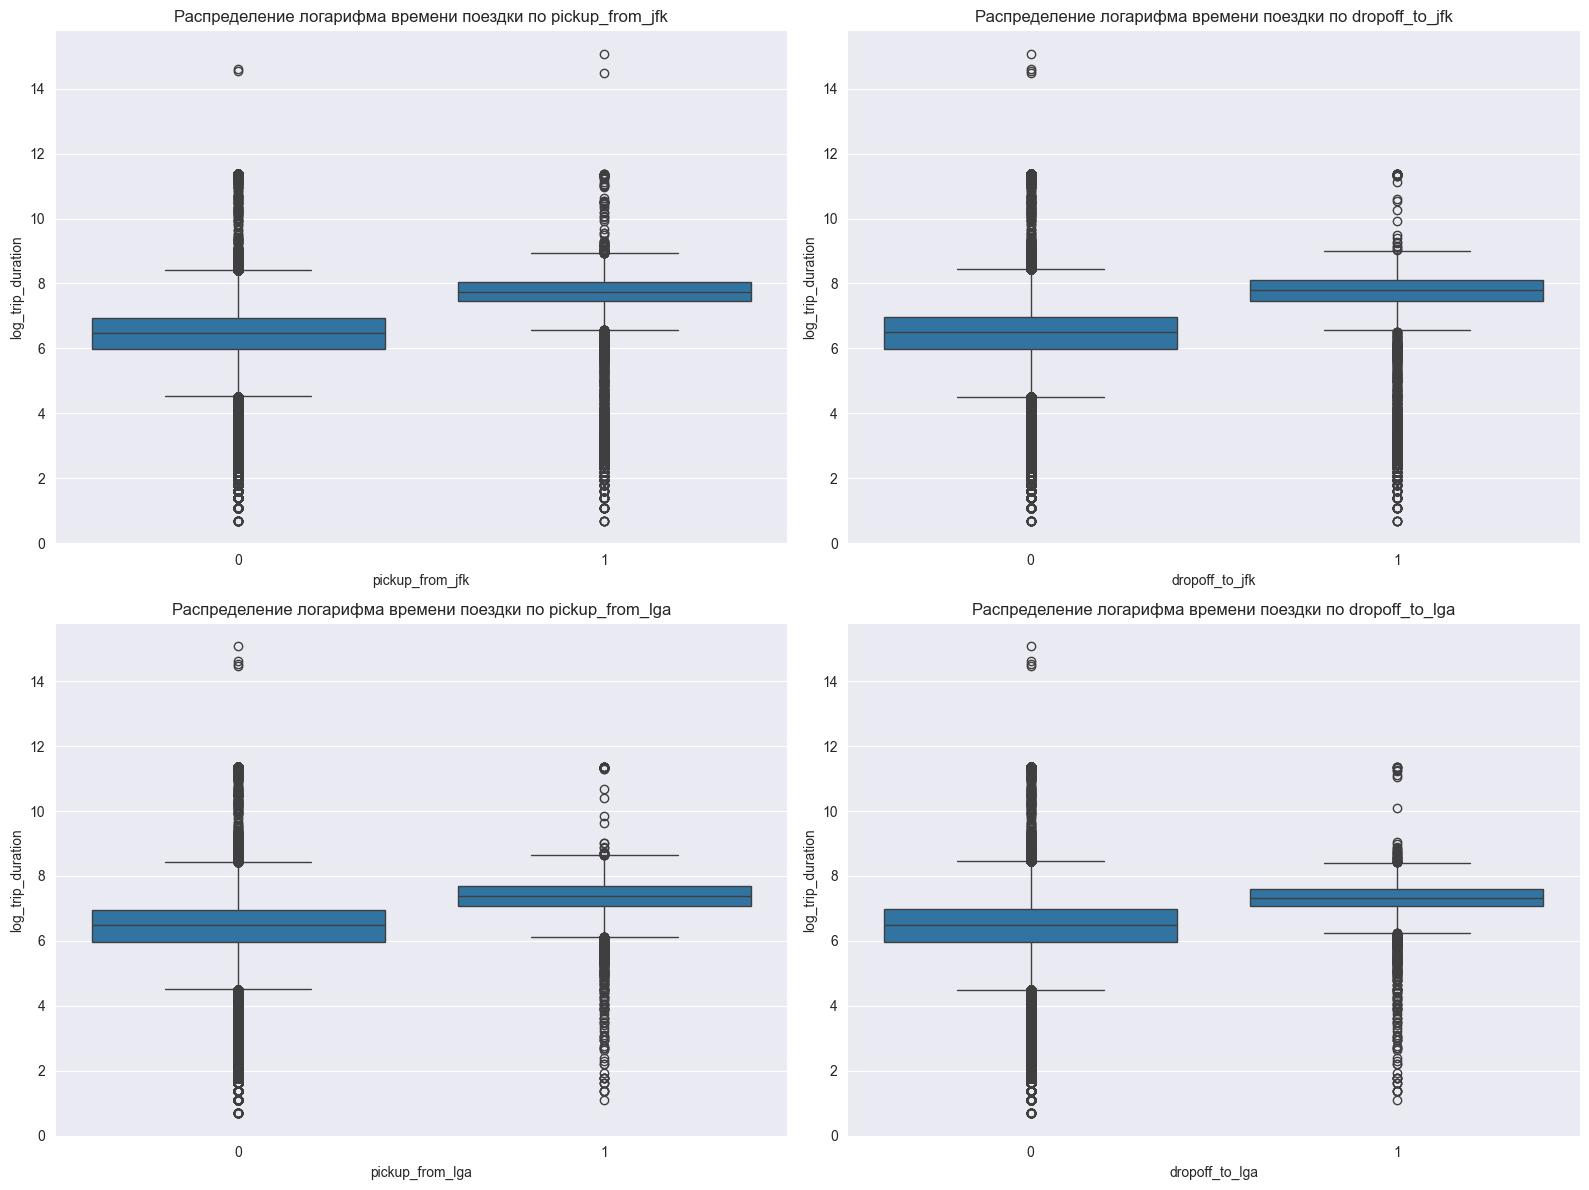

In [403]:
import seaborn as sns
import matplotlib.pyplot as plt

train_data, _ = train_test_split(data, test_size=0.3, random_state=42)
# Указываем созданные ранее признаки для визуализации
features = ['pickup_from_jfk', 'dropoff_to_jfk', 'pickup_from_lga', 'dropoff_to_lga']

# Рисуем ящики с усами для каждого признака
plt.figure(figsize=(16, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=feature, y='log_trip_duration', data=train_data)
    plt.title(f'Распределение логарифма времени поездки по {feature}')
    plt.xlabel(feature)
    plt.ylabel('log_trip_duration')

plt.tight_layout()
plt.show()


**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

Признаки получились хорошими, потому что как мы видим, длительность поездки из/в аэропорт больше чем средняя, а сами данные расположены более плотно.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишем трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. 

In [404]:
from sklearn.base import BaseEstimator, TransformerMixin


class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_rows=10, n_cols=10):
        self.n_rows = n_rows
        self.n_cols = n_cols

        self.min_lat = 40.701560  # Южная граница
        self.max_lat = 40.828178  # Северная граница
        self.min_lon = -74.017880  # Западная граница
        self.max_lon = -73.928130  # Восточная граница

    def fit(self, X, y=None):
        # Вычисляем шаг сетки для широты и долготы
        self.lat_step = (self.max_lat - self.min_lat) / self.n_rows
        self.lon_step = (self.max_lon - self.min_lon) / self.n_cols

        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['pickup_cell'] = self._get_cell(X_copy['pickup_latitude'], X_copy['pickup_longitude'])
        X_copy['dropoff_cell'] = self._get_cell(X_copy['dropoff_latitude'], X_copy['dropoff_longitude'])
        return X_copy

    def _get_cell(self, latitudes, longitudes):
        lat_idx = np.floor((latitudes - self.min_lat) / self.lat_step).astype(int)
        lon_idx = np.floor((longitudes - self.min_lon) / self.lon_step).astype(int)
        lat_idx = np.where((lat_idx >= 0) & (lat_idx < self.n_rows), lat_idx, -1)
        lon_idx = np.where((lon_idx >= 0) & (lon_idx < self.n_cols), lon_idx, -1)

        cell_idx = np.where((lat_idx == -1) | (lon_idx == -1), -1, lat_idx * self.n_cols + lon_idx)
        return cell_idx

    def show_map(self):
        """
        Визуализирует сетку на карте Манхэттена
        """
        center_lat = (self.max_lat + self.min_lat) / 2
        center_lon = (self.max_lon + self.min_lon) / 2

        m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

        for i in range(self.n_rows + 1):
            lat = self.min_lat + i * self.lat_step
            folium.PolyLine([(lat, self.min_lon), (lat, self.max_lon)], color="red").add_to(m)

        for j in range(self.n_cols + 1):
            lon = self.min_lon + j * self.lon_step
            folium.PolyLine([(self.min_lat, lon), (self.max_lat, lon)], color="red").add_to(m)

        return m


map_grid_transformer = MapGridTransformer(n_rows=7, n_cols=7)
map_grid_transformer.fit(data)

map_grid_transformer.show_map()

In [405]:
data = map_grid_transformer.transform(data)
data

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,...,haversine,log_haversine,is_rush_hour,is_free_traffic,pickup_from_jfk,dropoff_to_jfk,pickup_from_lga,dropoff_to_lga,pickup_cell,dropoff_cell
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,...,1.498521,0.915699,0,0,0,0,0,0,23,25
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,...,1.805507,1.031584,0,0,0,0,0,0,16,8
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,...,6.385098,1.999464,1,0,0,0,0,0,24,0
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,...,1.485498,0.910473,1,0,0,0,0,0,7,0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,...,1.188588,0.783257,0,0,0,0,0,0,38,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,N,6.658011,...,1.225080,0.799793,1,0,0,0,0,0,16,15
1458640,id1049543,1,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,N,6.486161,...,6.049836,1.953004,0,1,0,0,0,0,15,38
1458641,id2304944,2,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,N,6.639876,...,7.824606,2.177544,0,0,0,0,0,0,25,1
1458642,id2714485,1,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,N,5.924256,...,1.092564,0.738390,1,0,0,0,0,0,16,24


Обучим `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируем через one-hot-кодирование, числовые признаки отмасштабируем.

In [406]:
# Категориальные признаки
categorical_features = ['hour_of_day', 'day_of_week', 'month',
                        'pickup_cell', 'dropoff_cell',
                        'is_rush_hour', 'is_free_traffic',
                        'pickup_from_jfk', 'dropoff_to_jfk',
                        'pickup_from_lga', 'dropoff_to_lga',
                        'is_first_anomalous', 'is_second_anomalous']

# Числовые признаки
numerical_features = ['day_of_year', 'pickup_latitude', 'pickup_longitude',
                      'dropoff_latitude', 'dropoff_longitude', 'log_haversine']

train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
X_train, y_train = train_data[categorical_features + numerical_features], train_data['log_trip_duration']
X_test, y_test = test_data[categorical_features + numerical_features], test_data['log_trip_duration']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(random_state=42))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmsle = root_mean_squared_error(y_test, y_pred)
print(f'rmsle: {rmsle:.5f}')


rmsle: 0.47287


## Часть 3. Изучаем оставшиеся признаки

У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумаем, почему каждый из этих признаков может быть потенциально полезным.

Vendor ID указывает на компанию, предоставившую поездку. У разных компаний могут преобладать разные модели машин или тарифы, поэтому возможно признак сожержит новую информацию о таргете.

Количество пассажиров также может влиять на таргет, например, короткие поездки кажутся менее логичными для большого количества людей

Store And Fwd Flag указывает на то, была ли поездка сохранена в памяти и отправлена позже (возможно, из-за отсутствия связи). Если данные сохранялись и отправлялись позже, это может говорить о поездках в отдаленные районы с плохим соединением.

Посчитаем, сколько есть уникальных значений у каждого из этих признаков:

In [407]:
unique_vendor_id = data['vendor_id'].nunique()
unique_passenger_count = data['passenger_count'].nunique()
unique_store_and_fwd_flag = data['store_and_fwd_flag'].nunique()

print("Уникальных значений в 'vendor_id':", unique_vendor_id)
print("Уникальных значений в 'passenger_count':", unique_passenger_count)
print("Уникальных значений в 'store_and_fwd_flag':", unique_store_and_fwd_flag)


Уникальных значений в 'vendor_id': 2
Уникальных значений в 'passenger_count': 10
Уникальных значений в 'store_and_fwd_flag': 2


Построим "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

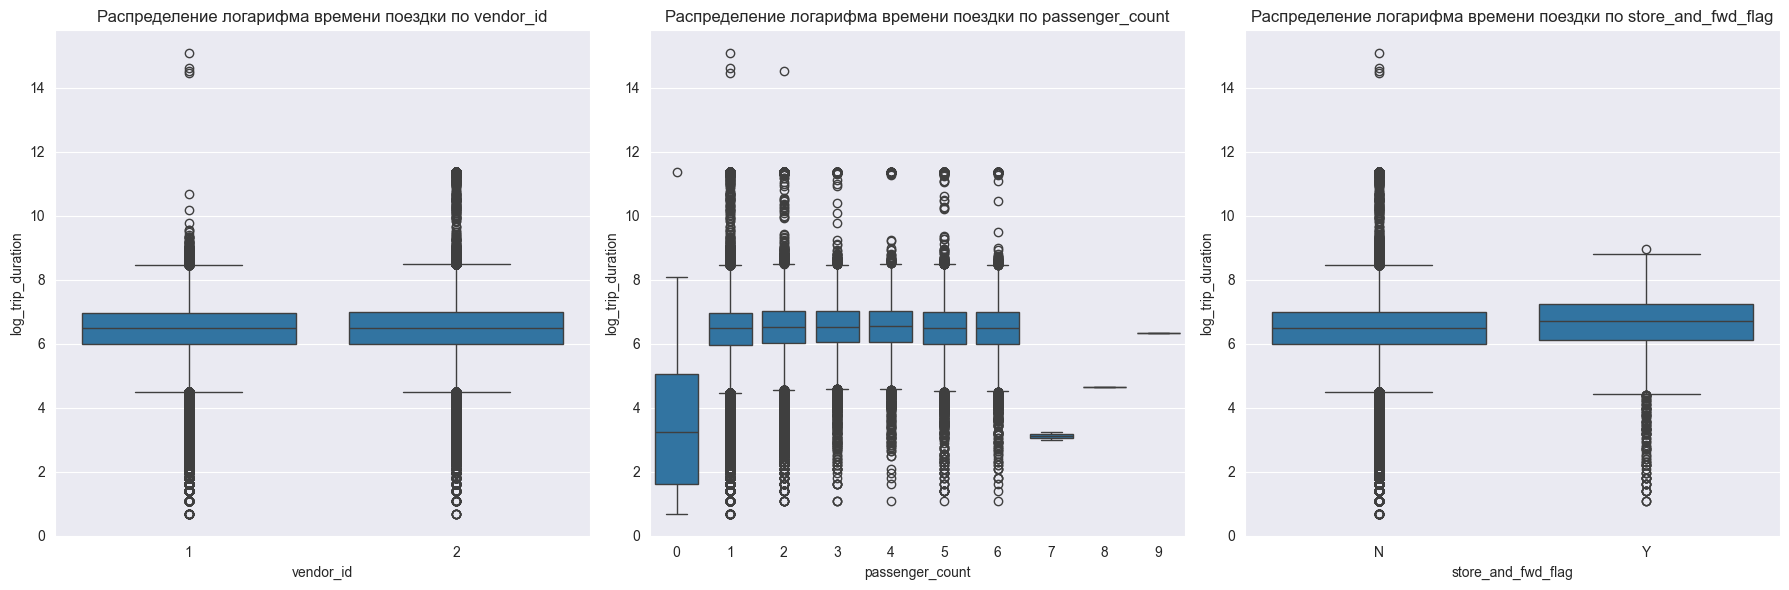

In [408]:
features = ['vendor_id', 'passenger_count', 'store_and_fwd_flag']

plt.figure(figsize=(18, 6))
for i, feature in enumerate(features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=feature, y='log_trip_duration', data=train_data)
    plt.title(f'Распределение логарифма времени поездки по {feature}')
    plt.xlabel(feature)
    plt.ylabel('log_trip_duration')

plt.tight_layout()
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [409]:
data['vendor_id'] = (data['vendor_id'] - 1).astype(int)

data['store_and_fwd_flag'] = (data['store_and_fwd_flag'] == 'Y').astype(int)

data

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,...,haversine,log_haversine,is_rush_hour,is_free_traffic,pickup_from_jfk,dropoff_to_jfk,pickup_from_lga,dropoff_to_lga,pickup_cell,dropoff_cell
0,id2875421,1,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,0,6.122493,...,1.498521,0.915699,0,0,0,0,0,0,23,25
1,id2377394,0,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,0,6.498282,...,1.805507,1.031584,0,0,0,0,0,0,16,8
2,id3858529,1,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,0,7.661527,...,6.385098,1.999464,1,0,0,0,0,0,24,0
3,id3504673,1,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,0,6.063785,...,1.485498,0.910473,1,0,0,0,0,0,7,0
4,id2181028,1,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,0,6.077642,...,1.188588,0.783257,0,0,0,0,0,0,38,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,1,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,0,6.658011,...,1.225080,0.799793,1,0,0,0,0,0,16,15
1458640,id1049543,0,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,0,6.486161,...,6.049836,1.953004,0,1,0,0,0,0,15,38
1458641,id2304944,1,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,0,6.639876,...,7.824606,2.177544,0,0,0,0,0,0,25,1
1458642,id2714485,0,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,0,5.924256,...,1.092564,0.738390,1,0,0,0,0,0,16,24


**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

Судя по графикам, разница в зависимости от значения этих признаков не такая большая (не считая passenger_count от 7 до 9, но это объясняется малым количеством объектов с такими значениями), следовательно, эти признаки вряд ли будут вносить большой вклад в предсказание

Проверим свои предположения, обучив модель в том числе и на этих трех признаках.

In [410]:
# Категориальные признаки
categorical_features = ['hour_of_day', 'day_of_week', 'month',
                        'pickup_cell', 'dropoff_cell',
                        'is_rush_hour', 'is_free_traffic',
                        'pickup_from_jfk', 'dropoff_to_jfk',
                        'pickup_from_lga', 'dropoff_to_lga',
                        'is_first_anomalous', 'is_second_anomalous',
                        'vendor_id', 'store_and_fwd_flag']

# Числовые признаки
numerical_features = ['day_of_year', 'pickup_latitude', 'pickup_longitude',
                      'dropoff_latitude', 'dropoff_longitude', 'log_haversine', 'passenger_count']

train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
X_train, y_train = train_data[categorical_features + numerical_features], train_data['log_trip_duration']
X_test, y_test = test_data[categorical_features + numerical_features], test_data['log_trip_duration']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(random_state=42))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmsle = root_mean_squared_error(y_test, y_pred)
print(f'rmsle: {rmsle:.5f}')

rmsle: 0.47267


## Часть 4. Улучшаем модель

В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

Text(0.5, 0, 'log_haversine')

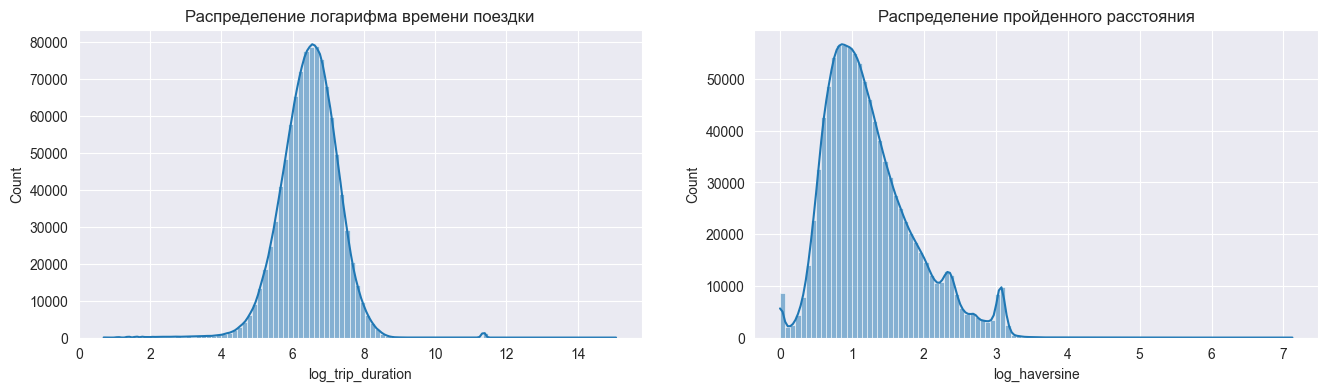

In [411]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
sns.histplot(train_data['log_trip_duration'], bins=100, kde=True)
plt.title("Распределение логарифма времени поездки")
plt.xlabel("log_trip_duration")

plt.subplot(1, 2, 2)
sns.histplot(train_data['log_haversine'], bins=100, kde=True)
plt.title("Распределение пройденного расстояния")
plt.xlabel("log_haversine")

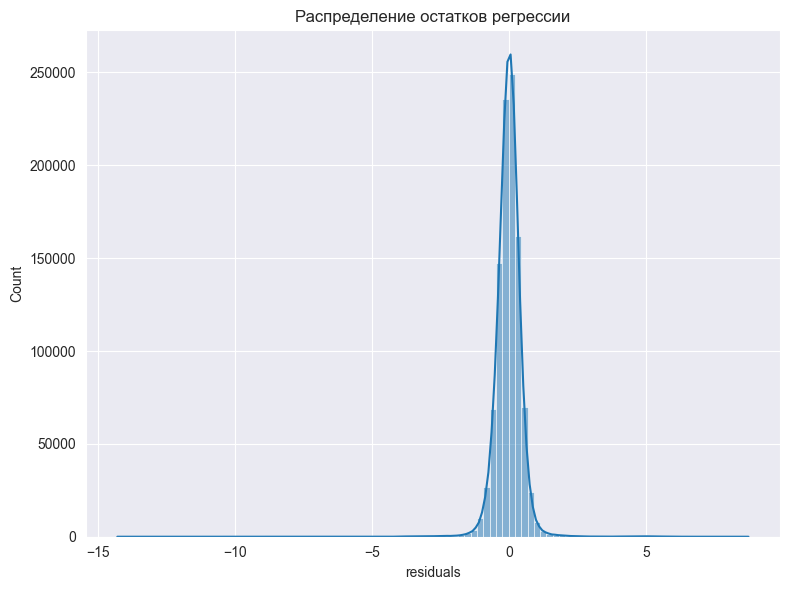

In [412]:
# 3. Гистограмма для остатков регрессии
y_pred_on_train = model.predict(X_train)
train_data['residuals'] = y_train - y_pred_on_train

# Построим гистограмму остатков
plt.figure(figsize=(8, 6))
sns.histplot(train_data['residuals'], bins=100, kde=True)
plt.title("Распределение остатков регрессии")
plt.xlabel("residuals")
plt.tight_layout()
plt.show()

In [413]:
duration_threshold = train_data['log_trip_duration'].quantile([0.001, 0.999])

haversine_threshold = train_data['log_haversine'].quantile([0.001, 0.999])

residual_threshold = np.abs(train_data['residuals']).quantile(0.999)

train_data = train_data[
    (train_data['log_trip_duration'] >= duration_threshold[0.001]) & (
            train_data['log_trip_duration'] <= duration_threshold[0.999]) &
    (train_data['log_haversine'] >= haversine_threshold[0.001]) & (
            train_data['log_haversine'] <= haversine_threshold[0.999]) &
    (train_data['residuals'] <= residual_threshold)
    ]

train_data = train_data.drop(columns=['residuals'])
print("Размер данных до очистки:", X_train.shape[0])
print("Размер данных после очистки:", train_data.shape[0])

Размер данных до очистки: 1021050
Размер данных после очистки: 1017836


Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объединим действительно редкие категории в одну, если такие имеются.

In [414]:
threshold = 0.01 * len(train_data)

rare_categories = {}

for feature in ['hour_of_day', 'day_of_week', 'month', 'pickup_cell', 'dropoff_cell']:  #  категориальные без бинарных
    value_counts = train_data[feature].value_counts()
    rare_values = value_counts[value_counts < threshold].index.tolist()
    if rare_values:
        rare_categories[feature] = rare_values
        # меняем на 100, чтобы не менять тип (такого значения нет в наших признаках)
        train_data[feature] = train_data[feature].apply(lambda x: 100 if x in rare_values else x)
        test_data[feature] = test_data[feature].apply(lambda x: 100 if x in rare_values else x)

print("Редкие категории:")
for feature, rare_vals in rare_categories.items():
    print(f"{feature}: {rare_vals}")

Редкие категории:
pickup_cell: [39, 2, 10, 40, 18, 4, 41, 46, 47, 20, 19, 5, 27, 48, 11, 12, 6, 3, 34, 13, 28, 21, 29, 43, 36, 42, 44, 37]
dropoff_cell: [10, 2, 40, 41, 47, 4, 18, 5, 46, 11, 19, 12, 48, 27, 20, 3, 6, 34, 13, 21, 28, 29, 36, 44, 37, 43, 35, 42, 45]


Обучим модель на очищенных данных и посчитаем качество на тестовой выборке.

In [415]:
X_train, y_train = train_data[categorical_features + numerical_features], train_data['log_trip_duration']
X_test, y_test = test_data[categorical_features + numerical_features], test_data['log_trip_duration']

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmsle = root_mean_squared_error(y_test, y_pred)
print(f'rmsle: {rmsle:.5f}')

rmsle: 0.47407


После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитаем количество признаков до и после кодирования категориальных признаков.

In [416]:
num_features_before = train_data.shape[1]

encoder = OneHotEncoder()
encoded_categorical_data = encoder.fit_transform(train_data[categorical_features])

num_new_categorical_features = encoded_categorical_data.shape[1]

num_features_after = num_features_before - len(categorical_features) + num_new_categorical_features

num_features_before, num_features_after

(26, 111)

Попробуем обучить не `Ridge`-, а `Lasso`-регрессию.

In [417]:
from sklearn.linear_model import Lasso

model_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

model_lasso.fit(X_train, y_train)

y_pred = model_lasso.predict(X_test)

rmsle = root_mean_squared_error(y_test, y_pred)
print(f'rmsle: {rmsle:.5f}')

rmsle: 0.79503


Разобьем _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберем оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерим качество лучшей полученной модели.

In [418]:
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# предобработка
X_train_preprocessed = preprocessor.fit_transform(X_train1)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

alpha_values = np.logspace(-4, 4, 50)

best_ridge_alpha = None
best_lasso_alpha = None
best_ridge_rmsle = float('inf')
best_lasso_rmsle = float('inf')

# для Ridge
for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha, random_state=42)
    ridge_model.fit(X_train_preprocessed, y_train1)
    y_pred_ridge = ridge_model.predict(X_val_preprocessed)
    rmsle_ridge = root_mean_squared_error(y_val, y_pred_ridge)
    if rmsle_ridge < best_ridge_rmsle:
        best_ridge_rmsle = rmsle_ridge
        best_ridge_alpha = alpha

num_zero_weights = []
lasso_mse_values = []
# для Lasso-регрессии
for alpha in alpha_values:
    lasso_model = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    lasso_model.fit(X_train_preprocessed, y_train1)
    y_pred_lasso = lasso_model.predict(X_val_preprocessed)

    zero_weights_count = np.sum(lasso_model.coef_ == 0)
    num_zero_weights.append(zero_weights_count)

    rmsle_lasso = root_mean_squared_error(y_val, y_pred_lasso)
    lasso_mse_values.append(rmsle_lasso)

    if rmsle_lasso < best_lasso_rmsle:
        best_lasso_rmsle = rmsle_lasso
        best_lasso_alpha = alpha

print(f'Лучший alpha для Ridge-регрессии: {best_ridge_alpha}, rmsle: {best_ridge_rmsle:.5f}')

print(f'Лучший alpha для Lasso-регрессии: {best_lasso_alpha}, rmsle: {best_lasso_rmsle:.5f}')

Лучший alpha для Ridge-регрессии: 0.013257113655901081, rmsle: 0.43027
Лучший alpha для Lasso-регрессии: 0.0001, rmsle: 0.43096


In [419]:
best_ridge = Ridge(alpha=best_ridge_alpha, random_state=42)
best_lasso = Lasso(alpha=best_lasso_alpha, random_state=42, max_iter=10000)

best_ridge.fit(preprocessor.fit_transform(X_train), y_train)
y_test_pred_ridge = best_ridge.predict(X_test_preprocessed)
test_rmsle_ridge = root_mean_squared_error(y_test, y_test_pred_ridge)
print(f'На тестовой выборке rmsle для лучшей модели Ridge: {test_rmsle_ridge:.5f}')

best_lasso.fit(preprocessor.fit_transform(X_train), y_train)
y_test_pred_lasso = best_lasso.predict(X_test_preprocessed)
test_rmsle_lasso = root_mean_squared_error(y_test, y_test_pred_lasso)
print(f'На тестовой выборке rmsle для лучшей модели Lasso: {test_rmsle_lasso:.5f}')

На тестовой выборке rmsle для лучшей модели Ridge: 0.47472
На тестовой выборке rmsle для лучшей модели Lasso: 0.47468


Сохраним наилучшее значение, как бенчмарк на будущее

In [420]:
best_rmsle = test_rmsle_ridge

Для каждого перебранного `alpha` для Lasso посчитаем количество нулевых весов в модели и нарисуем график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

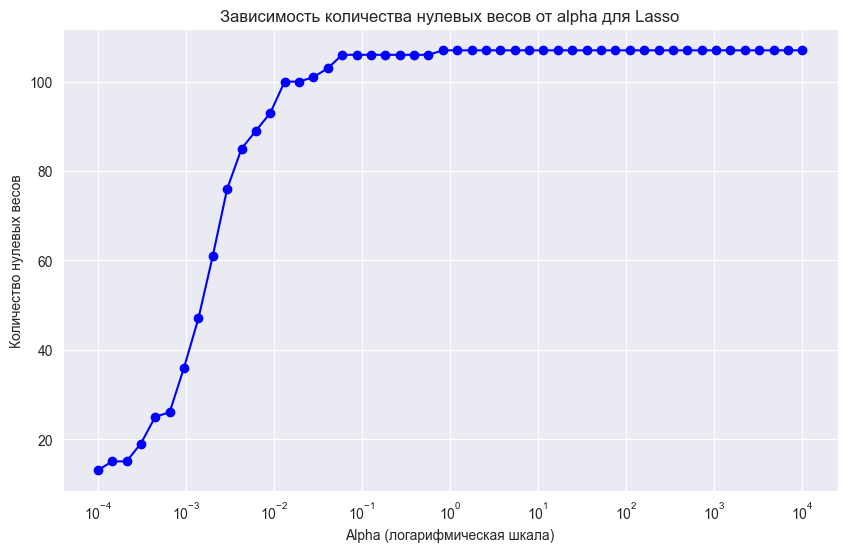

Alpha: 0.0020235896477251557, RMSLE: 0.4591001339498496, Потеря качества: 0.028143533888758565%


In [421]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(alpha_values, num_zero_weights, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel('Alpha (логарифмическая шкала)')
plt.ylabel('Количество нулевых весов')
plt.title('Зависимость количества нулевых весов от alpha для Lasso')
plt.grid(True)
plt.show()

target_zero_weights = X_train_preprocessed.shape[1] // 2
optimal_alpha = None
for alpha, zero_count, mse in zip(alpha_values, num_zero_weights, lasso_mse_values):
    if zero_count >= target_zero_weights:
        optimal_alpha = alpha
        optimal_mse = mse
        break

min_mse = min(lasso_mse_values)

mse_loss = optimal_mse - min_mse
print(f'Alpha: {optimal_alpha}, RMSLE: {optimal_mse}, Потеря качества: {mse_loss}%')


<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

In [422]:
train_data['cell_pair'] = list(zip(train_data['pickup_cell'], train_data['dropoff_cell']))

pair_counts = train_data['cell_pair'].value_counts()

top_pairs = pair_counts.head(100).index
top_pairs_dict = {pair: idx for idx, pair in enumerate(top_pairs)}

train_data['cell_pair'] = train_data['cell_pair'].apply(lambda x: top_pairs_dict.get(x, -1))

test_data['cell_pair'] = list(zip(test_data['pickup_cell'], test_data['dropoff_cell']))
test_data['cell_pair'] = test_data['cell_pair'].apply(lambda x: top_pairs_dict.get(x, -1))

test_data

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,...,log_haversine,is_rush_hour,is_free_traffic,pickup_from_jfk,dropoff_to_jfk,pickup_from_lga,dropoff_to_lga,pickup_cell,dropoff_cell,cell_pair
67250,id2793718,1,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,0,6.947937,...,1.325230,0,0,0,0,0,0,9,23,-1
1397036,id3485529,1,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,0,6.719013,...,1.084912,0,0,0,0,0,0,24,16,3
1021087,id1816614,1,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,0,6.421622,...,0.877455,0,0,0,0,0,0,16,17,5
951424,id1050851,1,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,0,6.766192,...,1.091473,0,0,0,0,0,0,9,16,23
707882,id0140657,0,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,0,8.510773,...,3.083640,0,0,1,0,0,0,-1,23,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876090,id2411525,0,2016-05-25 17:07:59,2,-73.983505,40.766369,-73.984795,40.785965,0,6.717805,...,1.157413,0,0,0,0,0,0,23,30,71
832420,id3782154,0,2016-06-11 11:18:45,1,-73.968147,40.800476,-73.953979,40.787643,0,6.163315,...,1.050724,0,0,0,0,0,0,38,32,-1
771092,id0699942,1,2016-05-20 06:30:38,5,-74.006210,40.733158,-73.997932,40.722610,0,6.171701,...,0.860608,0,0,0,0,0,0,7,8,-1
1032031,id3422152,0,2016-03-06 22:37:19,2,-73.990089,40.728859,-73.991234,40.765404,0,7.038784,...,1.622303,0,0,0,0,0,0,9,23,-1


Заново обучим модель на новых данных и посчитаем качество на тестовой выборке

In [423]:
categorical_features.append('cell_pair')

X_train, y_train = train_data[categorical_features + numerical_features], train_data['log_trip_duration']
X_test, y_test = test_data[categorical_features + numerical_features], test_data['log_trip_duration']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=best_ridge_alpha, random_state=42))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmsle = root_mean_squared_error(y_test, y_pred)
print(f'rmsle: {rmsle:.5f}')

rmsle: 0.46433
